In [178]:
%pylab inline
import numpy as np
import pylab as pl
import pandas as pd
import os
import calendar

from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

Populating the interactive namespace from numpy and matplotlib


In [2]:
from matplotlib.projections import PolarAxes, register_projection
from matplotlib.transforms import Affine2D, Bbox, IdentityTransform

class NorthPolarAxes(PolarAxes):
    '''
    A variant of PolarAxes where theta starts pointing north and goes
    clockwise.
    '''
    name = 'northpolar'

    class NorthPolarTransform(PolarAxes.PolarTransform):
        def transform(self, tr):
            xy   = np.zeros(tr.shape, np.float_)
            t    = tr[:, 0:1]
            r    = tr[:, 1:2]
            x    = xy[:, 0:1]
            y    = xy[:, 1:2]
            x[:] = r * np.sin(t)
            y[:] = r * np.cos(t)
            return xy

        transform_non_affine = transform

        def inverted(self):
            return NorthPolarAxes.InvertedNorthPolarTransform()

    class InvertedNorthPolarTransform(PolarAxes.InvertedPolarTransform):
        def transform(self, xy):
            x = xy[:, 0:1]
            y = xy[:, 1:]
            r = np.sqrt(x*x + y*y)
            theta = np.arctan2(y, x)
            return np.concatenate((theta, r), 1)

        def inverted(self):
            return NorthPolarAxes.NorthPolarTransform()

    def _set_lim_and_transforms(self):
        PolarAxes._set_lim_and_transforms(self)
        self.transProjection = self.NorthPolarTransform()
        self.transData = (
            self.transScale + 
            self.transProjection + 
            (self.transProjectionAffine + self.transAxes))
        self._xaxis_transform = (
            self.transProjection +
            self.PolarAffine(IdentityTransform(), Bbox.unit()) +
            self.transAxes)
        self._xaxis_text1_transform = (
            self._theta_label1_position +
            self._xaxis_transform)
        self._yaxis_transform = (
            Affine2D().scale(np.pi * 2.0, 1.0) +
            self.transData)
        self._yaxis_text1_transform = (
            #self._r_label1_position +
            Affine2D().scale(1.0 / 360.0, 1.0) +
            self._yaxis_transform)

register_projection(NorthPolarAxes)

In [3]:
r = np.arange(0, 2, 0.01)
theta = 2 * np.pi * r

In [4]:
r2 = np.random.random(len(theta))

In [5]:
times = pd.date_range(start='2015-01-01', end='2015-12-31', freq='D')

theta_times = np.arange(0.0,len(times),1.0)/len(times) * (2.0 * np.pi)

In [166]:
r3 = np.random.random(len(times)) * 10.
r3[50] = 20.
r3[180] = 30.

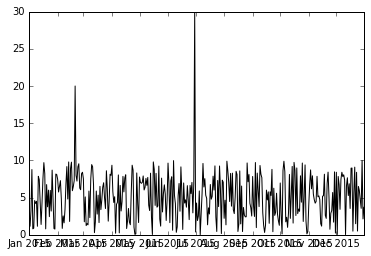

In [167]:
pl.plot_date(times, r3, 'k-')

In [168]:
df = pd.DataFrame(index=times)

In [169]:
df['data'] = r3
df['theta_labels'] = [calendar.month_abbr[df.index[i].month] if df.index[i].day == 15 else '' for i in xrange(len(df.index))] 

In [170]:
df.head()

,data,theta_labels
2015-01-01,2.540738,
2015-01-02,1.148937,
2015-01-03,3.225662,
2015-01-04,8.769892,
2015-01-05,0.801263,


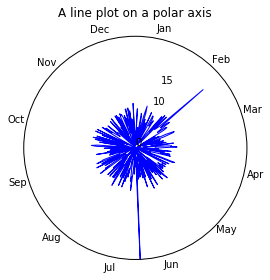

In [171]:
ax = plt.subplot(111, projection='northpolar') # use northpolar projection to set 0 azimuth to north
ax.set_theta_zero_location('N') # set theta zero location so that axis follows the northpolar projection
ax.set_theta_direction(-1) # set theta clockwise
ax.plot(theta_times, r3)#, edgecolor='none')
ax.set_rmax(25)
ax.set_rticks([0.0,10.0,15.0])  # less radial ticks
ax.set_xticks(theta_times)
ax.set_xticklabels(df.theta_labels)
ax.set_rlim((0,25))
ax.set_rlabel_position(22.5)  # get radial labels away from plotted line

ax.grid(False)

ax.set_title("A line plot on a polar axis", va='bottom')

In [172]:
# Create a colormap for red, green and blue and a norm to color
# f' < -0.5 red, f' > 0.5 blue, and the rest green
cmap = ListedColormap(['r', 'g', 'b'])
norm = BoundaryNorm([0, 10, 25, 100], cmap.N)

In [173]:
x = theta_times
y = df['data'].values
z = df['data'].values  # first derivative

# Create a set of line segments so that we can color them individually
# This creates the points as a N x 1 x 2 array so that we can stack points
# together easily to get the segments. The segments array for line collection
# needs to be numlines x points per line x 2 (x and y)
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

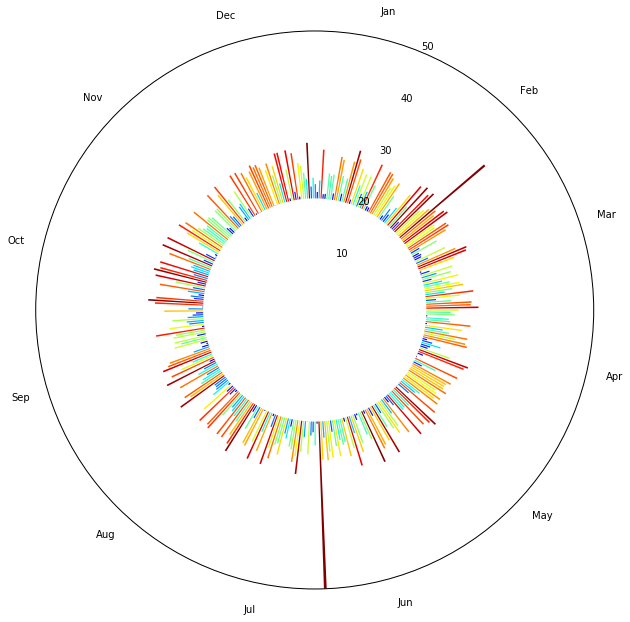

In [175]:
width = (2*np.pi) / len(theta_times) # set width to one day

fig = pl.figure(figsize=(10,10))
ax = pl.subplot(111, projection='northpolar') # use northpolar projection to set 0 azimuth to north
ax.set_theta_zero_location('N') # set theta zero location so that axis follows the northpolar projection
ax.set_theta_direction(-1) # set theta clockwise
bars = ax.bar(theta_times, r3, width=0.01, edgecolor='none', bottom=20)
#ax.add_collection(lc2)
#ax.set_rmax(25)
#ax.set_rticks([0.0,10.0,15.0])  # less radial ticks
ax.set_xticks(theta_times)
ax.set_xticklabels(df.theta_labels)
ax.set_rlim((0,50))
ax.set_rlabel_position(22.5)  # get radial labels away from plotted line

ax.grid(False)

# Use custom colors and opacity
for r, bar in zip(r3, bars):
    bar.set_facecolor(plt.cm.jet(r/10.))
    #bar.set_alpha(0.8)

#ax.set_title("A line plot on a polar axis", va='bottom')

IDEAS:

* color of bar = fraction of the day with rainfall (short thunderstorms = low percentage, continuous habagat = high %)
* columns for dataframe:
    * datetime
    * rainfall
    * theta_label
    * hours of rainfall fraction per day
* if value is NaN, plot gray lines instead of blank (or think of something to represent NaN so it's not confused with 0 rainfall)

### ACTUAL DATA

In [311]:
data_path = '../dataset/daily/2014'
data_file = '2014_GUIUAN.csv'

In [312]:
data = pd.read_csv(os.path.join(data_path, data_file))
data.set_index('DATE', inplace=True)

In [313]:
data.head()

,DAILY RAINFALL,TEMP MEAN,TEMP MAX,TEMP MIN
DATE,,,,
2014-01-01 00:00:00,28.702,26.111111,27.777778,22.777778
2014-01-02 00:00:00,53.848,26.666667,28.888889,23.333333
2014-01-03 00:00:00,12.954,26.111111,26.111111,21.666667
2014-01-04 00:00:00,4.064,27.222222,28.888889,23.333333
2014-01-05 00:00:00,62.992,26.666667,28.888889,23.333333


In [314]:
times = pd.date_range(start='2014-01-01', end='2014-12-31', freq='D')
df = pd.DataFrame(index=times)

In [315]:
df['theta_labels'] = [calendar.month_abbr[df.index[i].month] if df.index[i].day == 15 else '' for i in xrange(len(df.index))] 

In [316]:
df = df.combine_first(data)

In [326]:
rainvals = df['DAILY RAINFALL'].values
log_rainvalues = np.log10(rainvals)

C:\Anaconda\envs\wradlib\lib\site-packages\ipykernel\__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


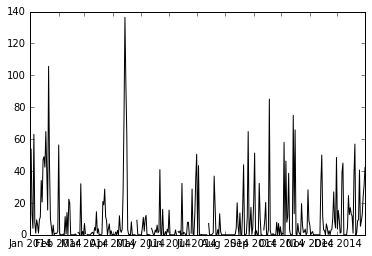

In [327]:
pl.plot_date(df.index, rainvals, 'k-')

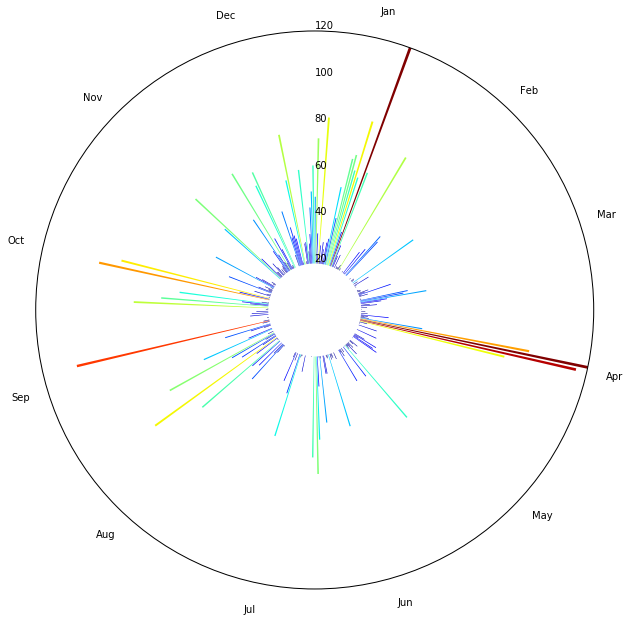

In [334]:
fig = pl.figure(figsize=(10,10))
ax = pl.subplot(111, projection='northpolar') # use northpolar projection to set 0 azimuth to north
ax.set_theta_zero_location('N') # set theta zero location so that axis follows the northpolar projection
ax.set_theta_direction(-1) # set theta clockwise
bars = ax.bar(theta_times, rainvals, width=0.01, edgecolor='none', bottom=20)
#ax.add_collection(lc2)
#ax.set_rmax(25)
#ax.set_rticks([0.0,10.0,15.0])  # less radial ticks
ax.set_xticks(theta_times)
ax.set_xticklabels(df.theta_labels)
ax.set_rlim((0,120))
ax.set_rlabel_position(0)  # get radial labels away from plotted line

ax.grid(False)

# Use custom colors and opacity
for r, bar in zip(rainvals, bars):
    bar.set_facecolor(plt.cm.jet(r/100.))
    #bar.set_alpha(0.8)

#ax.set_title("A line plot on a polar axis", va='bottom')

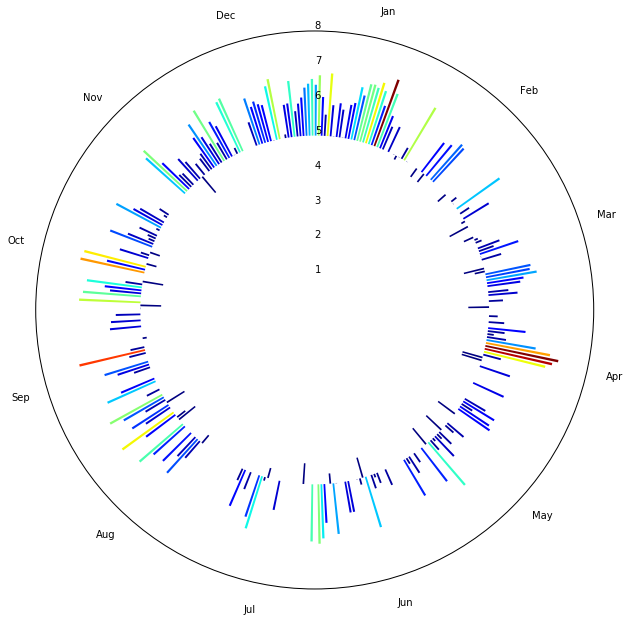

In [335]:
fig = pl.figure(figsize=(10,10))
ax = pl.subplot(111, projection='northpolar') # use northpolar projection to set 0 azimuth to north
ax.set_theta_zero_location('N') # set theta zero location so that axis follows the northpolar projection
ax.set_theta_direction(-1) # set theta clockwise
bars = ax.bar(theta_times, log_rainvalues, width=0.01, edgecolor='none', bottom=5)
#ax.add_collection(lc2)
#ax.set_rmax(25)
#ax.set_rticks([0.0,10.0,15.0])  # less radial ticks
ax.set_xticks(theta_times)
ax.set_xticklabels(df.theta_labels)
ax.set_rlim((0,8))
ax.set_rlabel_position(0)  # get radial labels away from plotted line

ax.grid(False)

# Use custom colors and opacity
for r, bar in zip(rainvals, bars):
    bar.set_facecolor(plt.cm.jet(r/100.))
    #bar.set_alpha(0.8)

#ax.set_title("A line plot on a polar axis", va='bottom')

In [338]:
np.log10(150)

2.1760912590556813